In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import scale

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))

In [5]:
target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

In [6]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count', 'adj_fire_bcount']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Binary Target Variable

In [7]:
train_data = target_df[(target_df['YEAR']>=1990) & (target_df['YEAR']<=2016)]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_bin = train_data['Y_bin_new_fire_month']

In [8]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_bin = test_data['Y_bin_new_fire_month'] 

### Random forest

In [215]:
cw = compute_class_weight('balanced', [0,1], Y_train_bin)

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0, 1], y=119      0
120      0
121      0
122      0
123      0
        ..
47706    0
47707    0
47708    0
47709    0
47710    0
Name: Y_bin_new_fire_month, Length: 27132, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [89]:
rf_clf_bin_bal = RandomForestClassifier(n_estimators = 100, class_weight= 'balanced_subsample').fit(X_train, Y_train_bin)

In [90]:
y_preds_rf_bin = rf_clf_bin_bal.predict(X_test)
y_proba_rf_bin = rf_clf_bin_bal.predict_proba(X_test)[:,1]

In [91]:
feat_import = pd.DataFrame()
feat_import['col'] = X_train.columns
feat_import['feature_importance'] = rf_clf_bin_bal.feature_importances_
feat_import.sort_values(['feature_importance'], ascending = False, inplace = True)
feat_import.head(20)

,col,feature_importance
55,2m_tmp_18hrs,0.023206
121,2m_tmp_18hrs_5y,0.022276
118,2m_tmp_0hrs_5y,0.021733
153,2m_tmp_18hrs_10y,0.020505
68,hist_fire_area_prop_5y,0.019989
169,tot_prcp_18hrs_10y,0.019874
69,hist_fire_area_prop_10y,0.019488
70,tot_area_fire_prev_1yr,0.016577
31,2m_tmp_0hrs,0.015002
150,2m_tmp_0hrs_10y,0.014816


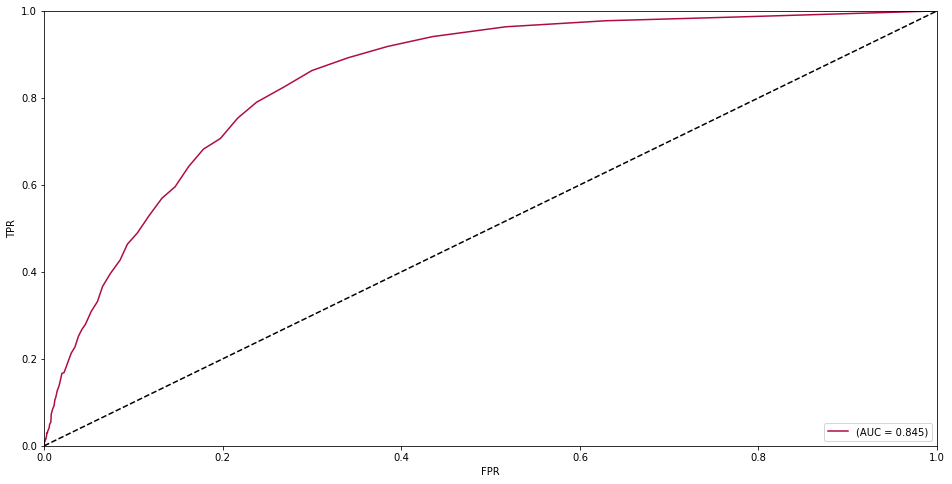

In [92]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
fpr_bal, tpr_bal, threshold = roc_curve(Y_test_bin, y_proba_rf_bin)
c = (np.random.rand(), np.random.rand(), np.random.rand())
roc_auc = auc(fpr_bal, tpr_bal)
plt.plot(fpr_bal, tpr_bal, color = c, label = '(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

In [93]:
print(pd.DataFrame(confusion_matrix(Y_test_bin, y_preds_rf_bin, normalize = 'true', labels = [0,1]), \
                   columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.997605  0.002395
1  0.979167  0.020833


In [14]:
corr_cols = list(X_train.columns)
corr_cols.append('Y_fire_class_size')
corr_cols.append('Y_bin')
X_train_corr = np.corrcoef(target_df[corr_cols].transpose())

In [15]:
print(X_train_corr.shape)
X_train_corr_df = pd.DataFrame(X_train_corr, columns = corr_cols, index = corr_cols)
X_train_corr_df.to_csv(os.path.join(data_dir, 'model_outputs/X_train_correlation_matrix.csv'))

(172, 172)


### Logistic Regression on the top X features from feature importances in random forest

In [52]:
def select_features_corr_imp(df, feat_import, rho_cutoff, n_features):
    feat_import.sort_values(['feature_importance'], inplace = True, ascending = False)
    full_feature_list = feat_import['col'].tolist()
    selected_features = [feat_import['col'].iloc[0]]
    i = 1
    while len(selected_features)<= n_features:
        f = full_feature_list[i]
        #print(f)
        test_features = selected_features + [f]
        corr_df = df[test_features].corr()
        #print(corr_df)
        #print(corr_df[corr_df[f]!=1][f].max())
        if corr_df[corr_df[f]!=1][f].max()< rho_cutoff:
            selected_features.append(f)
            i+= 1
        else:
            i+= 1
        
            
    #final full correlation dataframe for sanity check
    output_corr_df = df[selected_features].corr()
    return selected_features, output_corr_df

In [61]:
top_feats = {}
corr_df = {}
for i in np.arange(20, 40, 5):
    top_feats[i], corr_df[i] = select_features_corr_imp(X_train, feat_import, 0.75, i)
    print(top_feats[i])

['2m_tmp_18hrs_5y', 'hist_fire_area_prop_10y', 'tot_area_fire_prev_1yr', 'hist_cl_size_5y', 'tot_prcp_6hrs_10y', 'hist_cl_size_1y', 'tot_prcp_18hrs', 'hist_bin_10y', 'tot_prcp_18hrs_1y', 'U_wind_10m_0hrs', 'hist_prop_area_fire_1m', 'V_wind_10m_12hrs', 'U_wind_10m_12hrs', '2m_dewpoint_tmp_18hrs', 'leaf_high_veg_0hrs_5y', 'V_wind_10m_18hrs_1y', 'U_wind_10m_18hrs_1y', 'V_wind_10m_18hrs', 'V_wind_10m_0hrs_5y', 'leaf_high_veg_18hrs_5y', 'leaf_high_veg_12hrs_5y']
['2m_tmp_18hrs_5y', 'hist_fire_area_prop_10y', 'tot_area_fire_prev_1yr', 'hist_cl_size_5y', 'tot_prcp_6hrs_10y', 'hist_cl_size_1y', 'tot_prcp_18hrs', 'hist_bin_10y', 'tot_prcp_18hrs_1y', 'U_wind_10m_0hrs', 'hist_prop_area_fire_1m', 'V_wind_10m_12hrs', 'U_wind_10m_12hrs', '2m_dewpoint_tmp_18hrs', 'leaf_high_veg_0hrs_5y', 'V_wind_10m_18hrs_1y', 'U_wind_10m_18hrs_1y', 'V_wind_10m_18hrs', 'V_wind_10m_0hrs_5y', 'leaf_high_veg_18hrs_5y', 'leaf_high_veg_12hrs_5y', 'Total Arsons Cleared', 'leaf_high_veg_6hrs_5y', 'elev_range', 'hist_cl_size

#### Scale features

In [63]:
X_train_scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scale(X_test), columns = X_test.columns)

#### Subset by out feature importance subset dictionary we created above

In [64]:
X_train_LR = {}
X_test_LR = {}
for i in list(top_feats.keys()):
    X_train_LR[i] = X_train_scaled[top_feats[i]]
    X_test_LR[i] = X_test_scaled[top_feats[i]]

In [72]:
#regularization hyperparam options
cs = [10**i for i in range(-8, 2)] 

#### Train and score modeling 
We also will identify the best regularization hyperparameter for each # of top features

In [84]:
LR_bin = {}
LR_score = {}
LR_preds = {}
LR_auc = {}
LR_max_auc_ind = {}
for i in list(top_feats.keys()):
    LR_bin[i] = {}
    LR_score[i] = {}
    LR_preds[i] = {}
    LR_auc[i] = []
    for c in cs:
        LR_bin[i][c] = LogisticRegression(C = c, class_weight = 'balanced').fit(X_train_LR[i], Y_train_bin)
        LR_score[i][c] = LR_bin[i][c].predict_proba(X_test_LR[i])[:,1]
        LR_preds[i][c] = LR_bin[i][c].predict(X_test_LR[i])
        ##Find best feature # + regularization combo
        fpr, tpr, thresholds = roc_curve(Y_test_bin, LR_score[i][c])
        LR_auc[i].append(auc(fpr, tpr))
    LR_max_auc_ind[i] = LR_auc[i].index(np.max(LR_auc[i]))
print(LR_max_auc_ind)

{20: 6, 25: 5, 30: 6, 35: 5}


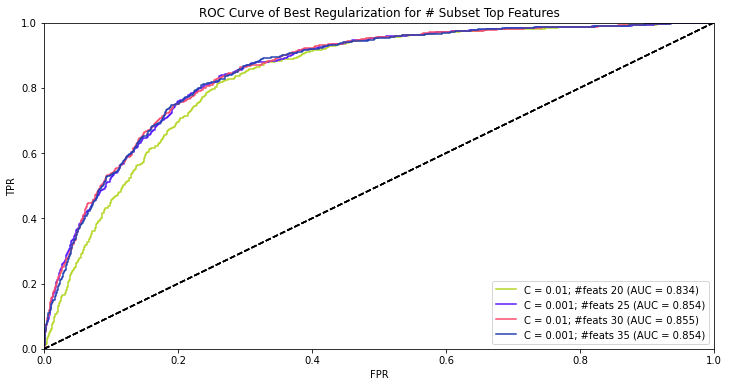

In [87]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (12,6))
for i in top_feats.keys():
    c = cs[LR_max_auc_ind[i]]
    fpr, tpr, thresholds = roc_curve(Y_test_bin, LR_score[i][c])
    roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    col = (np.random.rand(), np.random.rand(), np.random.rand())

    #plot current model ROC curve
    plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Logistic Regression ROC Curve of Best Regularization for # Subset Top Features')
    plt.legend(loc="lower right")
plt.show()

### SVM

In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (12,6))
for i in top_feats.keys():
    c = cs[LR_max_auc_ind[i]]
    fpr, tpr, thresholds = roc_curve(Y_test_bin, LR_score[i][c])
    roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    col = (np.random.rand(), np.random.rand(), np.random.rand())

    #plot current model ROC curve
    plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Logistic Regression ROC Curve of Best Regularization for # Subset Top Features')
    plt.legend(loc="lower right")
plt.show()